In [1]:
import sys
sys.path.append('../spp')

import process
import market
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [57]:
def_pipe = process.BaselineBinPipeline("TSLA", period="1y")
X_train, y_train, X_test, y_test = def_pipe.get_data()

[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_list[i][attribute_name+"_LnProf"] = lnprofs


In [58]:
class MovingAverageBin:
    def fit(self, x_data, y_data):
        return self
    def predict(self, data):
        prediction = []
        for index, row in data.iterrows():
            row_sum = 0
            for item in row:
                row_sum += item
            if row_sum / len(row) > row[-1]:
                prediction.append(1)
            else:
                prediction.append(0)
        return pd.DataFrame(prediction)
    
    def score(self, x_data, y_data):
        if len(y_data) != len(x_data):
            raise Exception("Different data length")
        return sum(np.array(self.predict(x_data)).flatten() == np.array(y_data).flatten()) / len(y_data)

## Moving Average baseline

Model earned 146991.58$ out of 186561.75$ starting from 100000$ 
Train accuracy 0.49 
Test accuracy  0.64


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:250: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


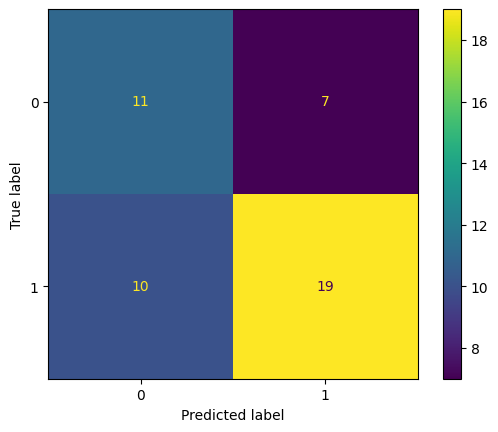

In [59]:
logreg = MovingAverageBin().fit(X_train, y_train)
y_train_pred_bin = logreg.predict(X_train)
y_test_pred_bin = logreg.predict(X_test)

df = def_pipe.get_test_price(y_test_pred_bin)  # ! Prediction_ExpProf will not be corret as we 
                                               # ! proposed bin not price

start_capital = 100000
tt = market.BinTraderTest(start_capital, y_test_pred_bin, df["Price_True"])
bt = market.BinTraderTest(start_capital, y_test, df["Price_True"])
traded_capital = tt.trade()
maximal_caital = bt.trade()
print(f"Model earned {(traded_capital):.2f}$ out of {maximal_caital:.2f}$ starting from {start_capital}$ ")

print(f"Train accuracy {logreg.score(X_train, y_train):.2f} \nTest accuracy  {logreg.score(X_test, y_test):.2f}")

_ = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_bin)